# -- Preliminary Analysis --

# 1. Load Dataset

Diabetes is one of the fastest growing chronic life-threatening diseases, affecting 422 million people worldwide as of 2018, according to the World Health Organization (WHO).

The disease often has a long asymptomatic phase, making early detection crucial for effective treatment and management. However, approximately 50% of people with diabetes remain undiagnosed due to the absence of early symptoms.

This dataset contains 520 observations, each with 17 characteristics. The data was collected through direct questionnaires and diagnostic results from patients at the Sylhet Diabetes Hospital in Sylhet, Bangladesh.

In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("andrewmvd/early-diabetes-classification")

print("Path to dataset files:", path)

path = path + "/diabetes_data.csv"
print("Path to dataset:", path)

100%|██████████| 2.10k/2.10k [00:00<00:00, 3.48MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/early-diabetes-classification/versions/1
Path to dataset: /root/.cache/kagglehub/datasets/andrewmvd/early-diabetes-classification/versions/1/diabetes_data.csv


# 2. Dataset Visualization and Feature Importance Analysis

## a. Load the data and visualize distribution of features

In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler

# load the file. ; is the separator
df = pd.read_csv(path, sep=';')
df.head()

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,Male,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,Male,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,Male,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,Male,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,Male,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


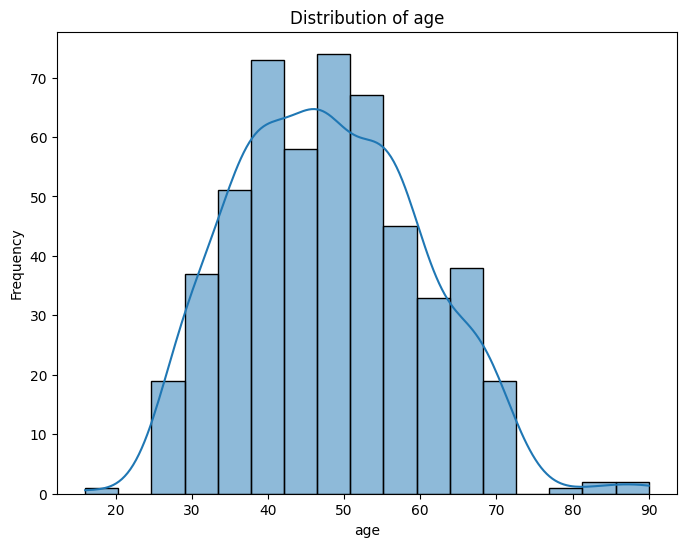

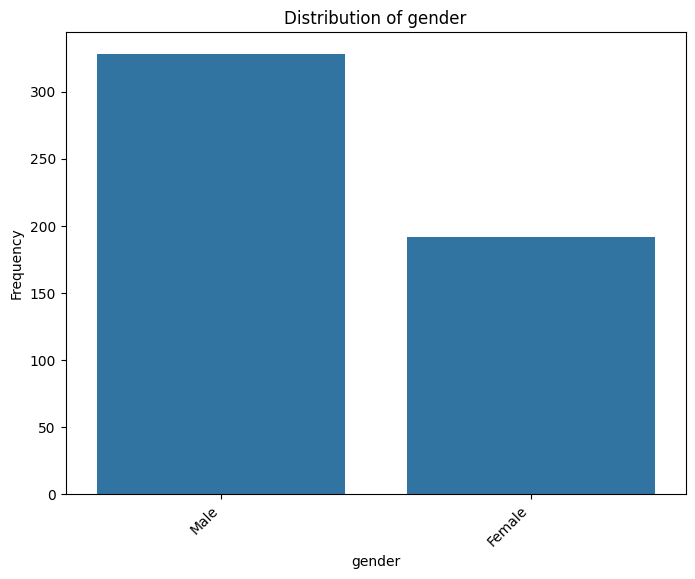

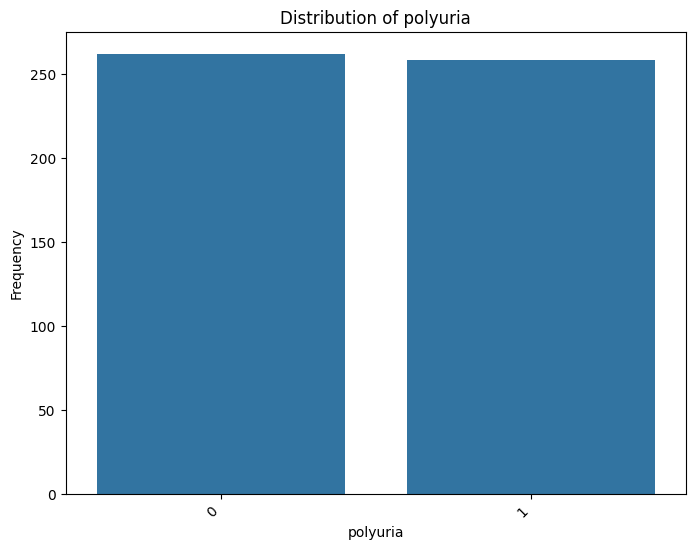

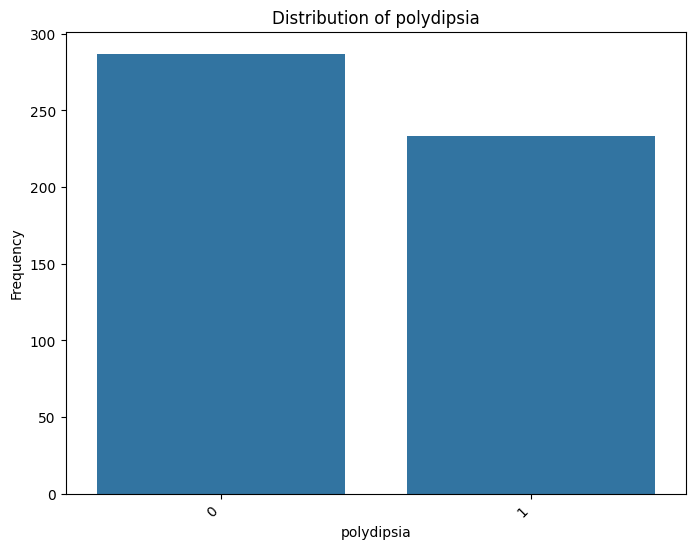

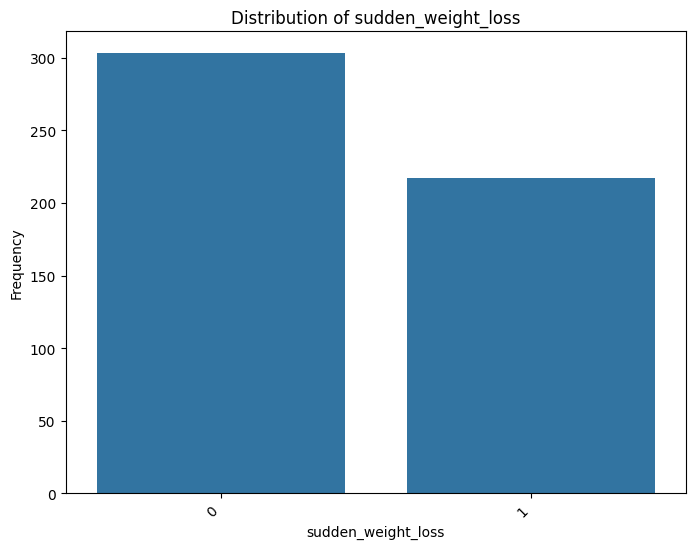

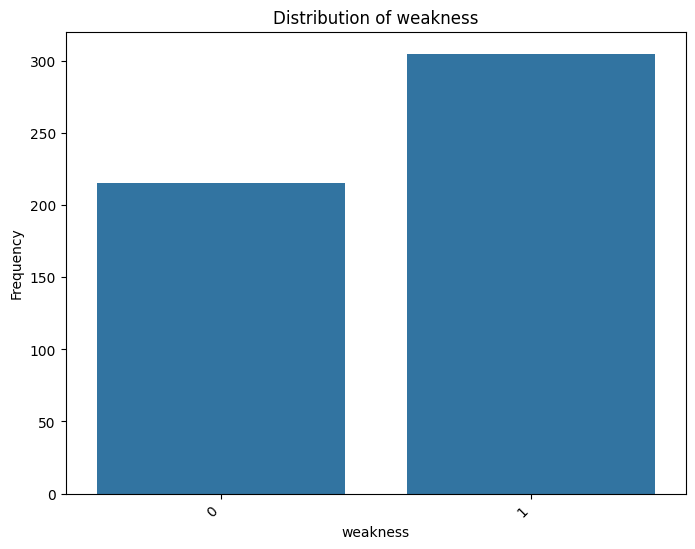

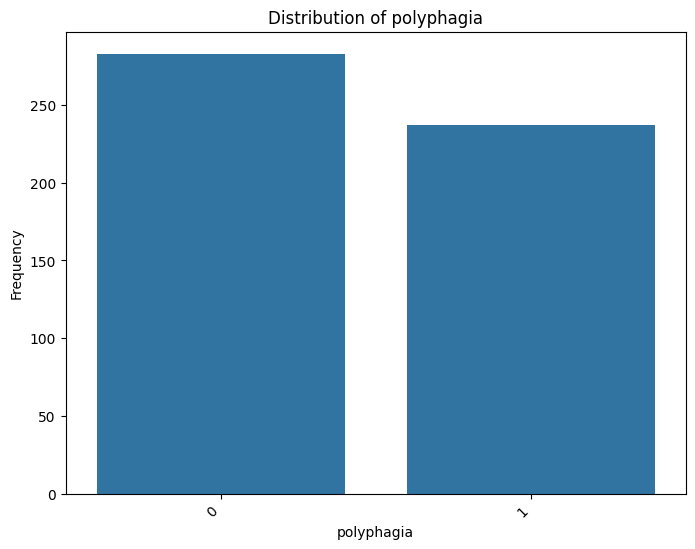

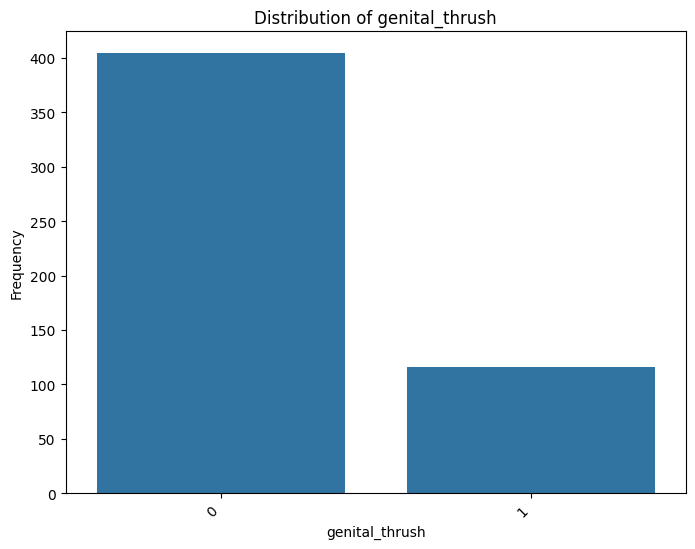

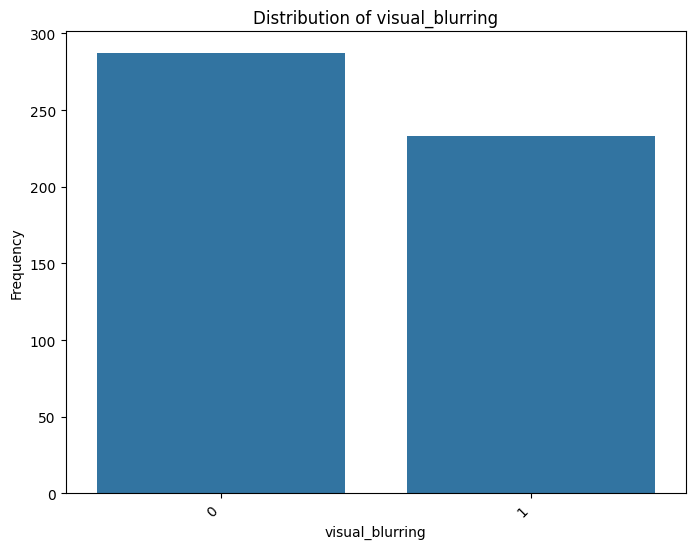

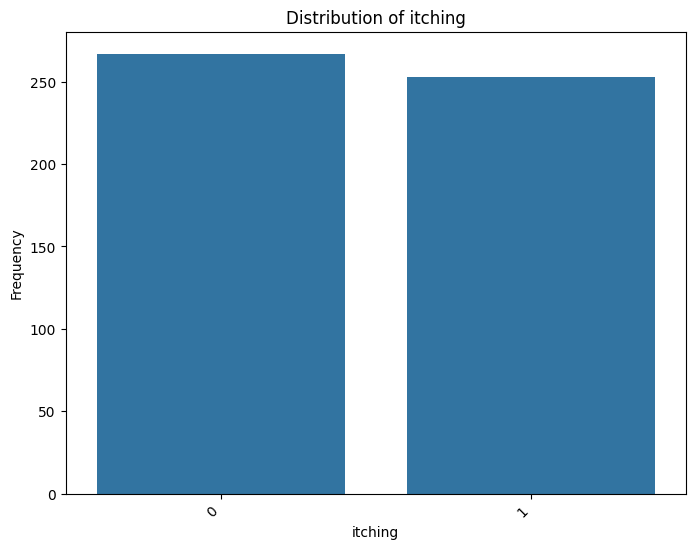

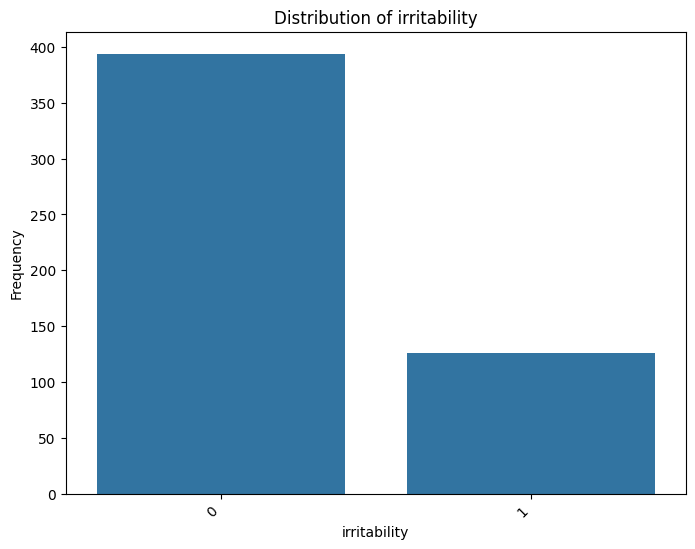

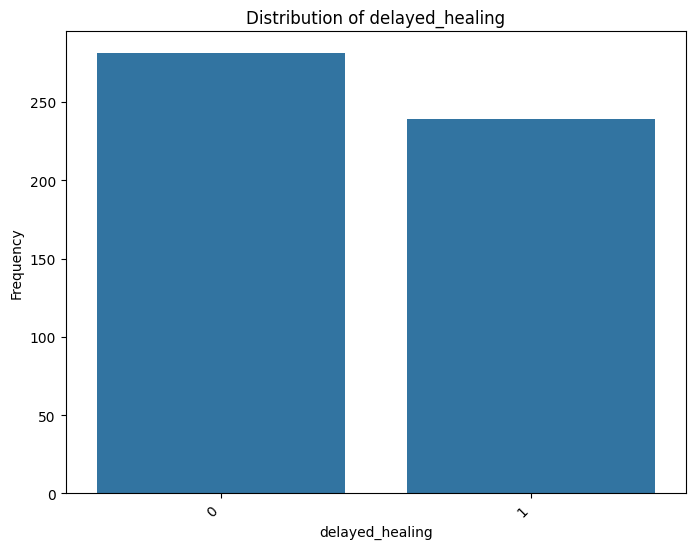

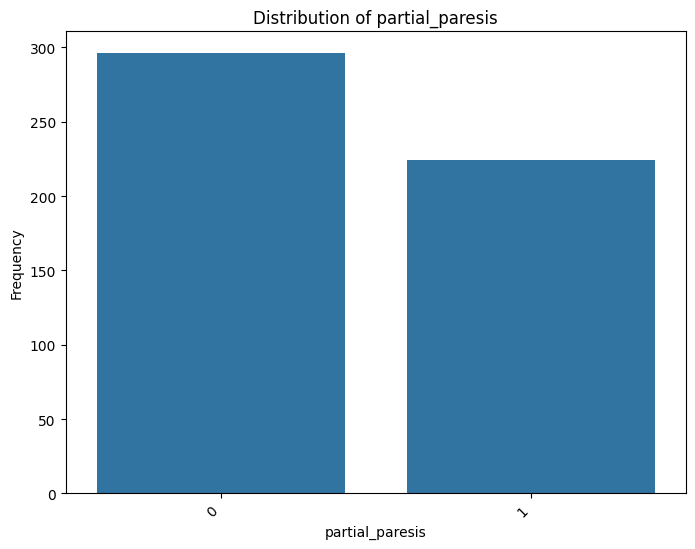

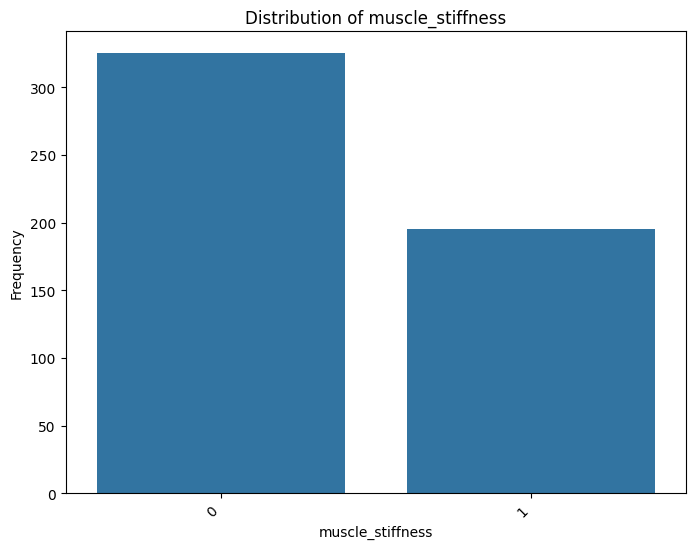

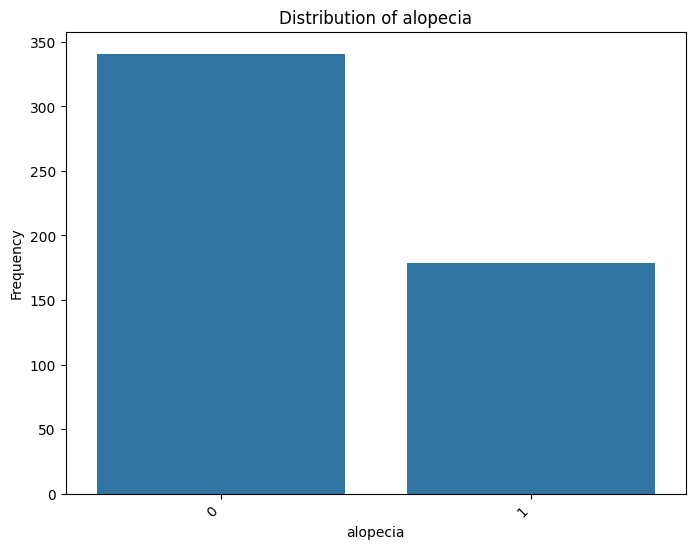

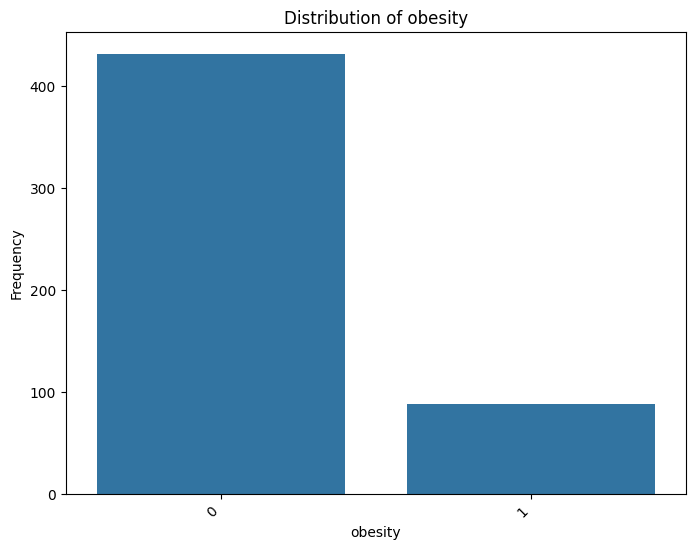

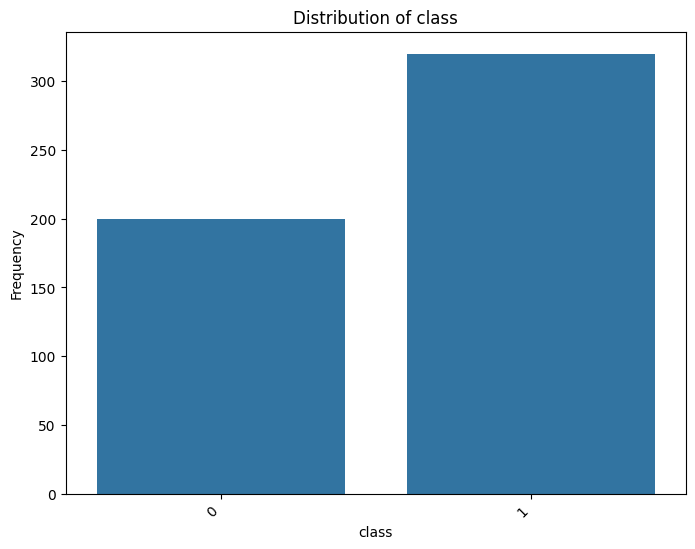

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop through each column (feature) and create a distribution plot
for column in df.columns:
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    if column=='age':  # Check if numeric
        sns.histplot(df[column], kde=True)  # Histogram with kernel density estimate
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()
    else: # Categorical features
        sns.countplot(x = column, data = df)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
        plt.show()

## b. Feature Importance Analysis 1 (Correlation Matrix)

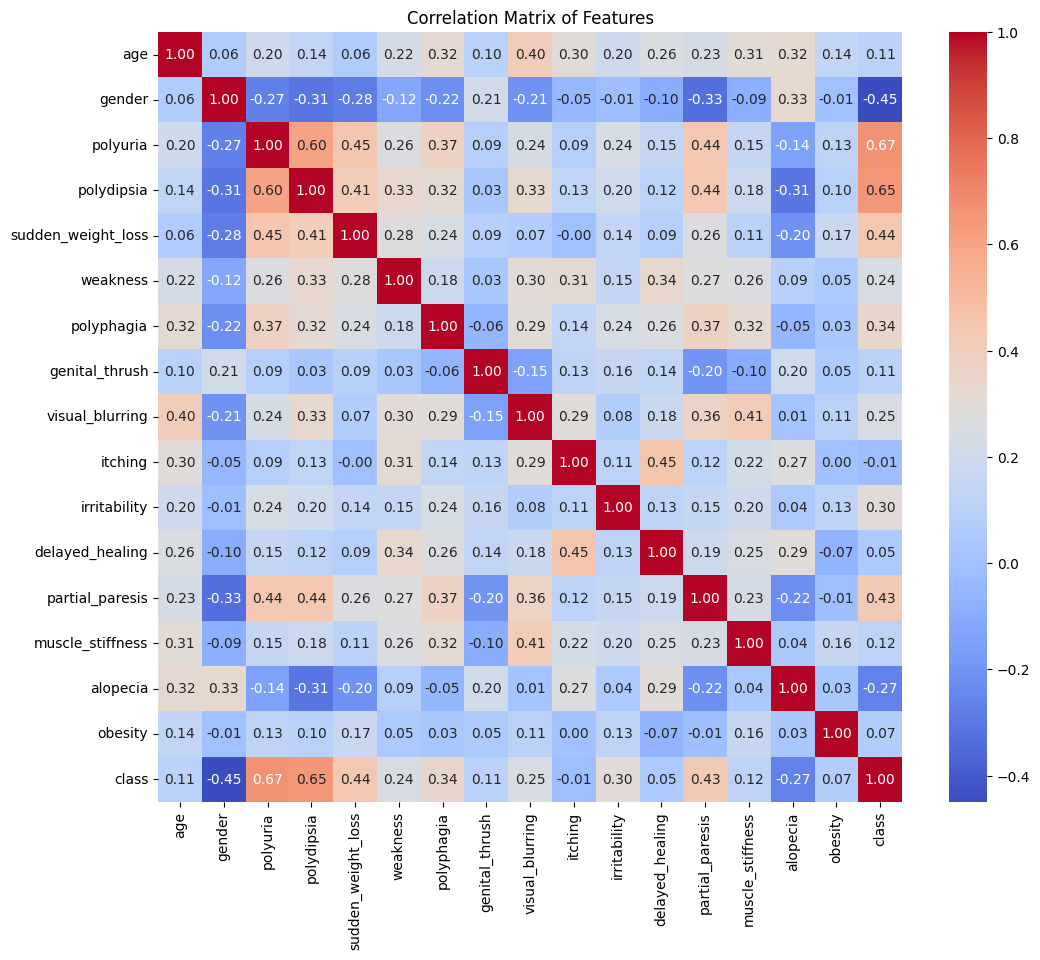

In [ ]:
# prompt: generate correlation matrix to rank the feature importance of features to predict the target variable 'class'

# convert gender from 'Male' -> 1 and 'Female" -> 0
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Get the correlation with the target variable 'class'
correlation_with_class = correlation_matrix['class'].drop('class')

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

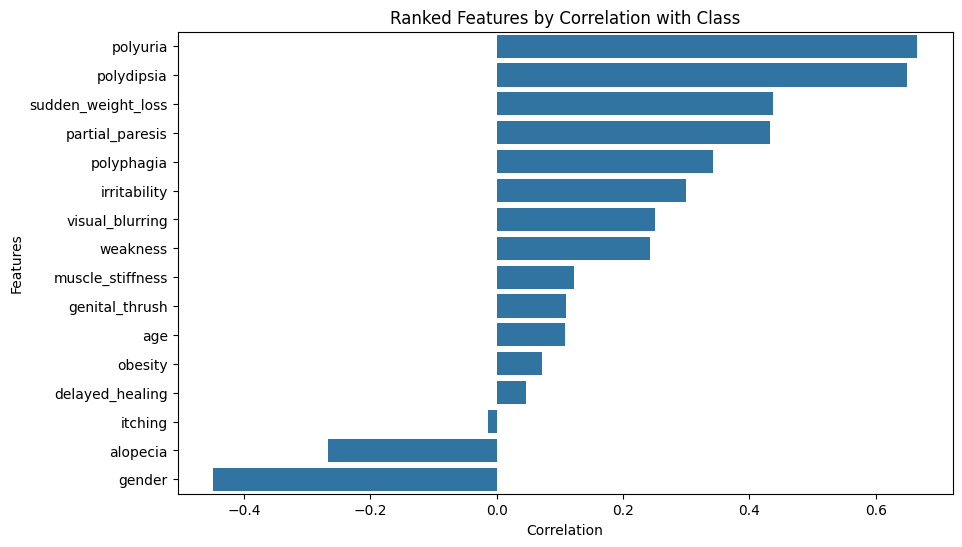

Absolute Feature Ranking: 
polyuria              0.665922
polydipsia            0.648734
gender                0.449233
sudden_weight_loss    0.436568
partial_paresis       0.432288
polyphagia            0.342504
irritability          0.299467
alopecia              0.267512
visual_blurring       0.251300
weakness              0.243275
muscle_stiffness      0.122474
genital_thrush        0.110288
age                   0.108679
obesity               0.072173
delayed_healing       0.046980
itching               0.013384
Name: class, dtype: float64


In [ ]:
# Rank features by absolute correlation with the target variable
ranked_features = correlation_with_class.sort_values(ascending=False)

# make it into a horizontal bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=ranked_features.values, y=ranked_features.index, orient='h')
plt.title('Ranked Features by Correlation with Class')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()

# print the correlation
ranked_features = correlation_with_class.abs().sort_values(ascending=False)
print("Absolute Feature Ranking: ")
print(ranked_features)

## c. Feature Importance Analysis 2 (SHAP Analysis on LR Model)

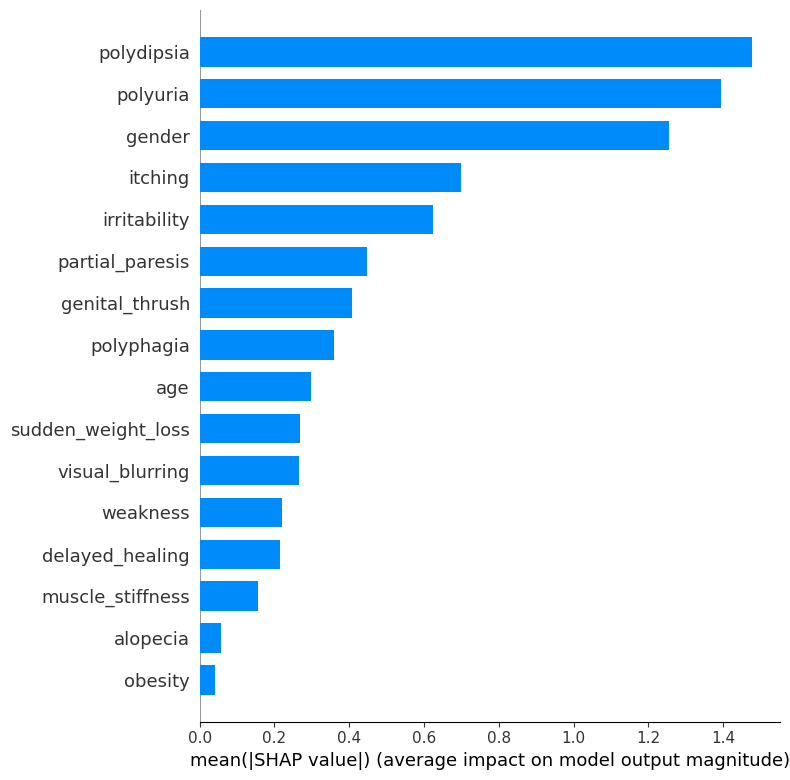

In [ ]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Define features (X) and target (y)
X = df.drop('class', axis=1)
y = df['class']

# Initialize and train a Logistic Regression model
model = LogisticRegression(max_iter=1000)  # Increased max_iter
model.fit(X, y)

# Calculate SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Plot feature importances
shap.summary_plot(shap_values, X, plot_type="bar")

# Conclusion: Feature Importance Analysis

## Results Overview:
1. Correlation Coefficient Analysis:
- The absolute ranking of features based on their correlation with the target variable places polyuria and polydipsia at the top, followed by gender, sudden_weight_loss, and partial_paresis. Features like itching, delayed_healing, and obesity have the lowest correlation values.

2. SHAP Value Analysis (Logistic Regression):
- The SHAP analysis for the logistic regression model also highlights polydipsia and polyuria as the most important features. However, it ranks gender, itching, and irritability higher compared to correlation analysis, and gives less importance to alopecia, delayed_healing, and obesity.

## Similarities:
1. Top Features: Both methods identify polyuria and polydipsia as the most influential features, which reflects their strong relationship with the target variable.

2. Middle-Ranked Features: Features like gender, partial_paresis, and sudden_weight_loss appear relatively important in both analyses.

## Differences:
1. Importance of Features with Weak Correlation:
- Correlation ranks itching, obesity, and delayed_healing as the least significant due to their minimal direct linear relationship with the target variable.
- SHAP analysis assigns higher importance to itching and includes genital_thrush prominently, likely due to their interaction effects or non-linear relationships captured in the logistic regression model.

2. Lower Importance of Alopecia:
- Correlation analysis places alopecia relatively higher, while SHAP values show it as less impactful. This may indicate that alopecia is less relevant to the final model's decision-making process.

## Reasoning for Differences:
The disparity arises from the fundamental differences in the two methods:

1. **Correlation Analysis** measures the direct linear relationship between a feature and the target variable, treating each feature independently.
2. **SHAP Values** consider the contribution of features in the context of a specific model. They account for interactions and non-linear effects, which are often missed by correlation.

# 3. On the Existence of Simpler Model

Reference: Semenova, L., Rudin, C., & Parr, R. (2022). On the Existence of Simpler Machine Learning Models. In 2022 ACM Conference on Fairness, Accountability, and Transparency (pp. 1827–1858). ACM.

https://doi.org/10.1145/3531146.3533232

The goal is to determine whether a simpler model can achieve performance comparable to more complex ones. This is assessed by examining the size of the Rashomon Set—the set of models within a specific performance range. A larger Rashomon Set suggests that simpler models may exist.

To practically evaluate this, we will test the performance of various machine learning algorithms, similar to the methodology in the referenced paper. Specifically, we will experiment with the following models:

- Logistic Regression
- Classification and Regression Tree (CART)
- Random Forest
- Gradient Boosted Tree
- Support Vector Machine (SVM)

## a. Load and process the data

In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler

# load the file. ; is the separator
df = pd.read_csv(path, sep=';')

# convert gender from 'Male' -> 1 and 'Female" -> 0
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# normalized the age variable using minmaxscaler so its between 0 and 1
scaler = MinMaxScaler()
df['age'] = scaler.fit_transform(df['age'].values.reshape(-1, 1))

y = df['class']
X = df.drop('class', axis=1)

df.head()

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,0.324324,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,0.567568,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,0.337838,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,0.391892,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,0.594595,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


## b. Cross-validate each model

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# 1. logistic regression
logreg = LogisticRegression(max_iter=1000)
cv_results = cross_validate(logreg, X, y, cv=5, scoring=['accuracy'], return_train_score=True)
logreg_train_accuracy = cv_results['train_accuracy'].mean()
logreg_test_accuracy = cv_results['test_accuracy'].mean()
print(f"Logistic Regression - Train Accuracy: {logreg_train_accuracy:.4f}, Test Accuracy: {logreg_test_accuracy:.4f}")

# 2. Decision Tree Classifier
dt = DecisionTreeClassifier()
cv_results = cross_validate(dt, X, y, cv=5, scoring=['accuracy'], return_train_score=True)
dt_train_accuracy = cv_results['train_accuracy'].mean()
dt_test_accuracy = cv_results['test_accuracy'].mean()
print(f"Decision Tree Classifier - Train Accuracy: {dt_train_accuracy:.4f}, Test Accuracy: {dt_test_accuracy:.4f}")

# 3. Random Forest Classifier
rf = RandomForestClassifier()
cv_results = cross_validate(rf, X, y, cv=5, scoring=['accuracy'], return_train_score=True)
rf_train_accuracy = cv_results['train_accuracy'].mean()
rf_test_accuracy = cv_results['test_accuracy'].mean()
print(f"Random Forest - Train Accuracy: {rf_train_accuracy:.4f}, Test Accuracy: {rf_test_accuracy:.4f}")

# 4. Gradient Boosting Classifier
gb = GradientBoostingClassifier()
cv_results = cross_validate(gb, X, y, cv=5, scoring=['accuracy'], return_train_score=True)
gb_train_accuracy = cv_results['train_accuracy'].mean()
gb_test_accuracy = cv_results['test_accuracy'].mean()
print(f"Gradient Boosting Classifier - Train Accuracy: {gb_train_accuracy:.4f}, Test Accuracy: {gb_test_accuracy:.4f}")

# 5. Support Vector Classifier
svc = SVC()
cv_results = cross_validate(svc, X, y, cv=5, scoring=['accuracy'], return_train_score=True)
svc_train_accuracy = cv_results['train_accuracy'].mean()
svc_test_accuracy = cv_results['test_accuracy'].mean()
print(f"Support Vector Classifier - Train Accuracy: {svc_train_accuracy:.4f}, Test Accuracy: {svc_test_accuracy:.4f}")

Logistic Regression - Train Accuracy: 0.9332, Test Accuracy: 0.9269
Decision Tree Classifier - Train Accuracy: 1.0000, Test Accuracy: 0.9558
Random Forest - Train Accuracy: 1.0000, Test Accuracy: 0.9750
Gradient Boosting Classifier - Train Accuracy: 0.9986, Test Accuracy: 0.9692
Support Vector Classifier - Train Accuracy: 0.9837, Test Accuracy: 0.9635


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Ensure the target variable y is binary for roc_auc to work
# Check your data: `y` should have exactly two unique values

# 1. Logistic Regression
logreg = LogisticRegression(max_iter=1000)
cv_results = cross_validate(logreg, X, y, cv=5, scoring='roc_auc', return_train_score=True)
logreg_train_auc = cv_results['train_score'].mean()
logreg_test_auc = cv_results['test_score'].mean()
print(f"Logistic Regression - Train AUC: {logreg_train_auc:.4f}, Test AUC: {logreg_test_auc:.4f}")

# 2. Decision Tree Classifier
dt = DecisionTreeClassifier()
cv_results = cross_validate(dt, X, y, cv=5, scoring='roc_auc', return_train_score=True)
dt_train_auc = cv_results['train_score'].mean()
dt_test_auc = cv_results['test_score'].mean()
print(f"Decision Tree Classifier - Train AUC: {dt_train_auc:.4f}, Test AUC: {dt_test_auc:.4f}")

# 3. Random Forest Classifier
rf = RandomForestClassifier()
cv_results = cross_validate(rf, X, y, cv=5, scoring='roc_auc', return_train_score=True)
rf_train_auc = cv_results['train_score'].mean()
rf_test_auc = cv_results['test_score'].mean()
print(f"Random Forest - Train AUC: {rf_train_auc:.4f}, Test AUC: {rf_test_auc:.4f}")

# 4. Gradient Boosting Classifier
gb = GradientBoostingClassifier()
cv_results = cross_validate(gb, X, y, cv=5, scoring='roc_auc', return_train_score=True)
gb_train_auc = cv_results['train_score'].mean()
gb_test_auc = cv_results['test_score'].mean()
print(f"Gradient Boosting Classifier - Train AUC: {gb_train_auc:.4f}, Test AUC: {gb_test_auc:.4f}")

# 5. Support Vector Classifier
# SVC does not directly support probability outputs; set `probability=True` to enable it
svc = SVC(probability=True)
cv_results = cross_validate(svc, X, y, cv=5, scoring='roc_auc', return_train_score=True)
svc_train_auc = cv_results['train_score'].mean()
svc_test_auc = cv_results['test_score'].mean()
print(f"Support Vector Classifier - Train AUC: {svc_train_auc:.4f}, Test AUC: {svc_test_auc:.4f}")

Logistic Regression - Train AUC: 0.9799, Test AUC: 0.9695
Decision Tree Classifier - Train AUC: 1.0000, Test AUC: 0.9544
Random Forest - Train AUC: 1.0000, Test AUC: 0.9944
Gradient Boosting Classifier - Train AUC: 1.0000, Test AUC: 0.9875
Support Vector Classifier - Train AUC: 0.9988, Test AUC: 0.9945


## c. Generate bar graph for Accuracy

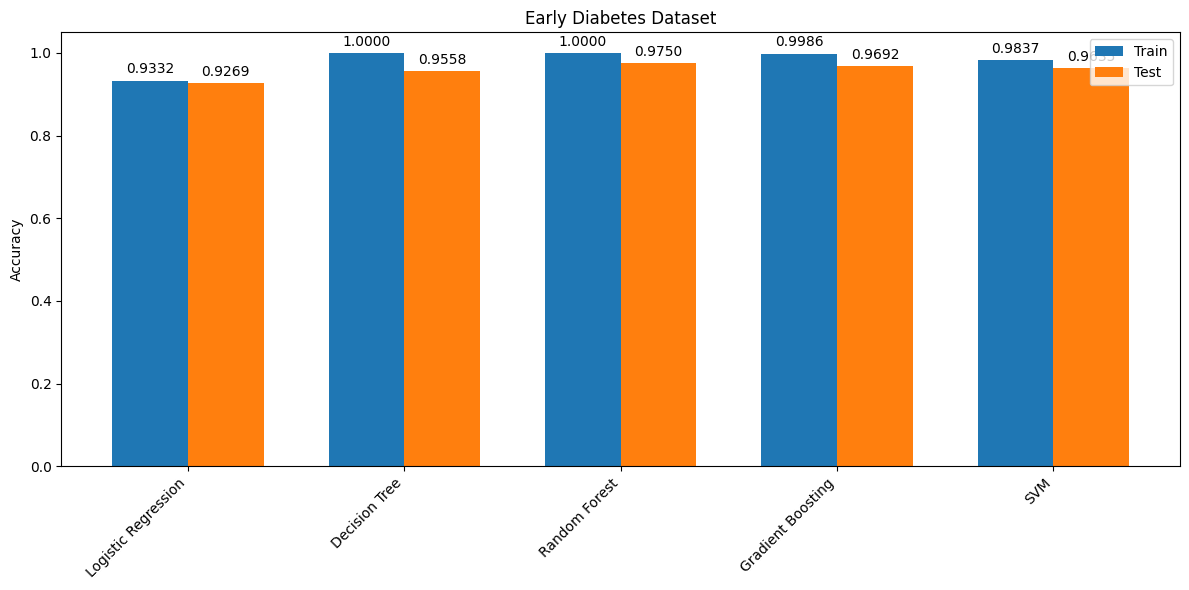

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample accuracy data (replace with your actual data)
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVM']
train_accuracies = [logreg_train_accuracy, dt_train_accuracy, rf_train_accuracy, gb_train_accuracy, svc_train_accuracy]
test_accuracies = [logreg_test_accuracy, dt_test_accuracy, rf_test_accuracy, gb_test_accuracy, svc_test_accuracy]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Train')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Early Diabetes Dataset')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Add accuracy values on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

# Conclusion: On the Existence of Simpler Model

The results of the cross-validation demonstrate that simpler machine learning models can potentially achieve performance similar to more complex ones. For instance, Logistic Regression achieved a test accuracy of 92.69%, while more complex models such as Random Forest and Gradient Boosting Classifier achieved 97.50% and 96.92%, respectively. The relatively close performance across models suggests a large Rashomon Set, indicating the existence of simpler, interpretable models that are effective. This reinforces the importance of exploring simplicity in machine learning without compromising predictive accuracy.

# Next Step:

1. Generate a scorecard model using FasterRisk
2. Analyze its performance and compare it with other machine learning models
3. Analyze the feature that is used in the scorecard. (Does the feature in the scorecard aligns with other feature importance analysis that we've done on the preliminary)

# -- Final Analysis --

## 1. Code for FasterRisk

In [ ]:
!pip install fasterrisk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478.4/478.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.2.0
    Uninstalling pyparsing-3.2.0:
      Successfully uninstalled pyparsing-3.2.0
  Attempting uninstall: pillow
    Found existing installation: pillow 11.0.0
    Uninstalling pillow-11.0.0:
      Successfully uninstalled pillow-11.0.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
  Attempting uninstall: pandas
    

In [ ]:
# ------------------------
# Imports
import pandas as pd
import numpy as np
from statistics import mean
from sklearn.model_selection import StratifiedKFold
from fasterrisk.binarization_util import convert_continuous_df_to_binary_df
from fasterrisk.fasterrisk import RiskScoreOptimizer, RiskScoreClassifier
from sklearn.model_selection import train_test_split
import random
# ------------------------

# --------------------------------------------------------------------------
# SCORE CARD K-FOLD CROSS VALIDATION ALGORITHM
def KFOLDCV(X_arr, Y_arr, X_featureNames, K, maxSparsity, criteria, key):
    # ------------------------
    # Step 1: initialize variables and StratifiedKFold
    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=key)

    output_acc = dict()
    output_auc = dict()
    for j in range(1, maxSparsity+1):
        output_acc[j] = 0
        output_auc[j] = 0
    # ------------------------

    # ------------------------
    # Step 2: Iterate over folds
    for i , (train_index, test_index) in enumerate(skf.split(X_arr, Y_arr)):
        print(f"Evaluating Fold {i+1}:")

        # TRAIN AND TEST SET FOR TUNING
        X_train = X_arr[train_index]
        Y_train = Y_arr[train_index]
        X_test = X_arr[test_index]
        Y_test = Y_arr[test_index]

        result_acc, result_auc = [], []
        # Step 2.1: Sparsity iterator. Iterate over the different sparsity and take the mean ACC and AUC of the top 10 best models
        for j in range(1, maxSparsity+1):
            sparsity = j

            RiskScoreOptimizer_m = RiskScoreOptimizer(X = X_train, y = Y_train, k = sparsity)
            RiskScoreOptimizer_m.optimize()
            multipliers, sparseDiversePool_beta0_integer, sparseDiversePool_betas_integer = RiskScoreOptimizer_m.get_models()


            test_acc_arr, test_auc_arr = [], []
            num_models = min(10, len(multipliers))
            for model_index in range(num_models):
                multiplier = multipliers[model_index]
                intercept = sparseDiversePool_beta0_integer[model_index]
                coefficients = sparseDiversePool_betas_integer[model_index]

                RiskScoreClassifier_m = RiskScoreClassifier(multiplier, intercept, coefficients)
                RiskScoreClassifier_m.reset_featureNames(X_featureNames)
                #RiskScoreClassifier_m.print_model_card()

                train_loss = RiskScoreClassifier_m.compute_logisticLoss(X_train, Y_train)
                train_acc, train_auc = RiskScoreClassifier_m.get_acc_and_auc(X_train, Y_train)
                test_acc, test_auc = RiskScoreClassifier_m.get_acc_and_auc(X_test, Y_test)

                #print("The logistic loss on the training set is {}".format(train_loss))
                #print("The training accuracy and AUC are {:.3f}% and {:.3f}".format(train_acc*100, train_auc))
                #print("The test accuracy and AUC are are {:.3f}% and {:.3f}\n".format(test_acc*100, test_auc))

                test_acc_arr.append(test_acc)
                test_auc_arr.append(test_auc)

            # # Step 2.2: Take the mean ACC and AUC over the folds
            sparsity_acc = mean(test_acc_arr)
            sparsity_auc = mean(test_auc_arr)
            output_acc[j] += sparsity_acc
            output_auc[j] += sparsity_auc
            #print(j)
            #print(sparsity_acc)
            #print(sparsity_auc)
    # ------------------------

    # ------------------------
    # Step 3: Print output result from K-FoldCV
    print(output_acc)
    print(output_auc)

    best_acc = max(output_acc, key=lambda k:output_acc[k])
    best_auc = max(output_auc, key=lambda k:output_auc[k])

    print('RESULTS (ACC):')
    print('BEST SPARSITY: ' + (str)(best_acc))
    print('TEST ACCURACY: ' + (str)(output_acc[best_acc]/K))

    print('\nRESULTS (AUC):')
    print('BEST SPARSITY: ' + (str)(best_auc))
    print('TEST AUC: ' + (str)(output_auc[best_auc]/K))

    if(criteria == 'ACC'):
        return best_acc, output_acc[best_acc]/K
    else:
        return best_auc, output_auc[best_auc]/K
    # ------------------------

# --------------------------------------------------------------------------

In [ ]:
# --------------------------------------------------------------------------
# PREPROCESSOR
def pp(df, targetFeature):
    Y = df[targetFeature]
    X = df.drop([targetFeature], axis=1)

    X_binarized = convert_continuous_df_to_binary_df(X)
    X_featureNames = list(X_binarized.columns)
    X_arr = np.asarray(X_binarized)
    Y_arr = np.asarray(Y)

    return X_arr, Y_arr, X_featureNames
# --------------------------------------------------------------------------

In [ ]:
# --------------------------------------------------------------------------
# HELPER FUNCTION TO CONSTRUCT MODEL
def buildModel(X_train, X_test, Y_train, Y_test, X_featureNames, sparsity, modelAmount):
    RiskScoreOptimizer_m = RiskScoreOptimizer(X = X_train, y = Y_train, k = sparsity)
    RiskScoreOptimizer_m.optimize()
    multipliers, sparseDiversePool_beta0_integer, sparseDiversePool_betas_integer = RiskScoreOptimizer_m.get_models()
    print("We generate {} risk score models from the sparse diverse pool".format(len(multipliers)))

    num_models = min(modelAmount, len(multipliers))
    for model_index in range(num_models):
        multiplier = multipliers[model_index]
        intercept = sparseDiversePool_beta0_integer[model_index]
        coefficients = sparseDiversePool_betas_integer[model_index]

        RiskScoreClassifier_m = RiskScoreClassifier(multiplier, intercept, coefficients)
        RiskScoreClassifier_m.reset_featureNames(X_featureNames)
        RiskScoreClassifier_m.print_model_card()

        train_loss = RiskScoreClassifier_m.compute_logisticLoss(X_train, Y_train)
        train_acc, train_auc = RiskScoreClassifier_m.get_acc_and_auc(X_train, Y_train)
        test_acc, test_auc = RiskScoreClassifier_m.get_acc_and_auc(X_test, Y_test)

        print("The logistic loss on the training set is {}".format(train_loss))
        print("The training accuracy and AUC are {:.3f}% and {:.3f}".format(train_acc*100, train_auc))
        print("The test accuracy and AUC are are {:.3f}% and {:.3f}\n".format(test_acc*100, test_auc))
# --------------------------------------------------------------------------

In [ ]:
# PIPELINE EXAMPLE

df = pd.read_csv(path, sep=';')

# convert class=0 to class=-1 and class=1 to class=1
df['class'] = df['class'].map({0: -1, 1: 1})

# convert gender from 'Male' -> 1 and 'Female" -> 0
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# 1. Pre-Process ~ pp(fileName, targetFeature)
X_arr, Y_arr, X_featureNames = pp(df, 'class')

# 2. Split Data ~ train_test_split(X, y, test_size)
X_train, X_test, Y_train, Y_test = train_test_split(X_arr, Y_arr, test_size=0.2, random_state=100, stratify=Y_arr)

# 3. Parameter tuning using kfold cross validation ~ KFOLDCV(X_arr, Y_arr, X_featureNames, K, maxSparsity, criteria, key)
s, value = KFOLDCV(X_train, Y_train, X_featureNames, K=5, maxSparsity=7, criteria='AUC', key=200)

# 4. Generate the score card ~ buildModel(X_train, X_test, Y_train, Y_test, X_featureNames, sparsity, modelAmount)
buildModel(X_train, X_test, Y_train, Y_test, X_featureNames, s, 10)

# --------------------------------------------------------------------------

Converting continuous features to binary features in the dataframe......
We select thresholds for each continuous feature by sampling (without replacement) <= max_num_thresholds_per_feature values from all unique values in that feature column.
Finish converting continuous features to binary features......
Evaluating Fold 1:
Evaluating Fold 2:
Evaluating Fold 3:
Evaluating Fold 4:
Evaluating Fold 5:
{1: 4.055364314400459, 2: 4.290160642570281, 3: 4.518789443488239, 4: 4.442484222604705, 5: 4.54424842226047, 6: 4.526678141135972, 7: 4.6298336201950665}
{1: 4.167585784313726, 2: 4.481099170437406, 3: 4.759149934012067, 4: 4.786313002765208, 5: 4.822209653092006, 6: 4.8324953258547, 7: 4.858799288946347}
RESULTS (ACC):
BEST SPARSITY: 7
TEST ACCURACY: 0.9259667240390133

RESULTS (AUC):
BEST SPARSITY: 7
TEST AUC: 0.9717598577892694
We generate 3 risk score models from the sparse diverse pool
The Risk Score is:
1.               age<=66      3 point(s) |   ...
2.             gender<=0      4 p

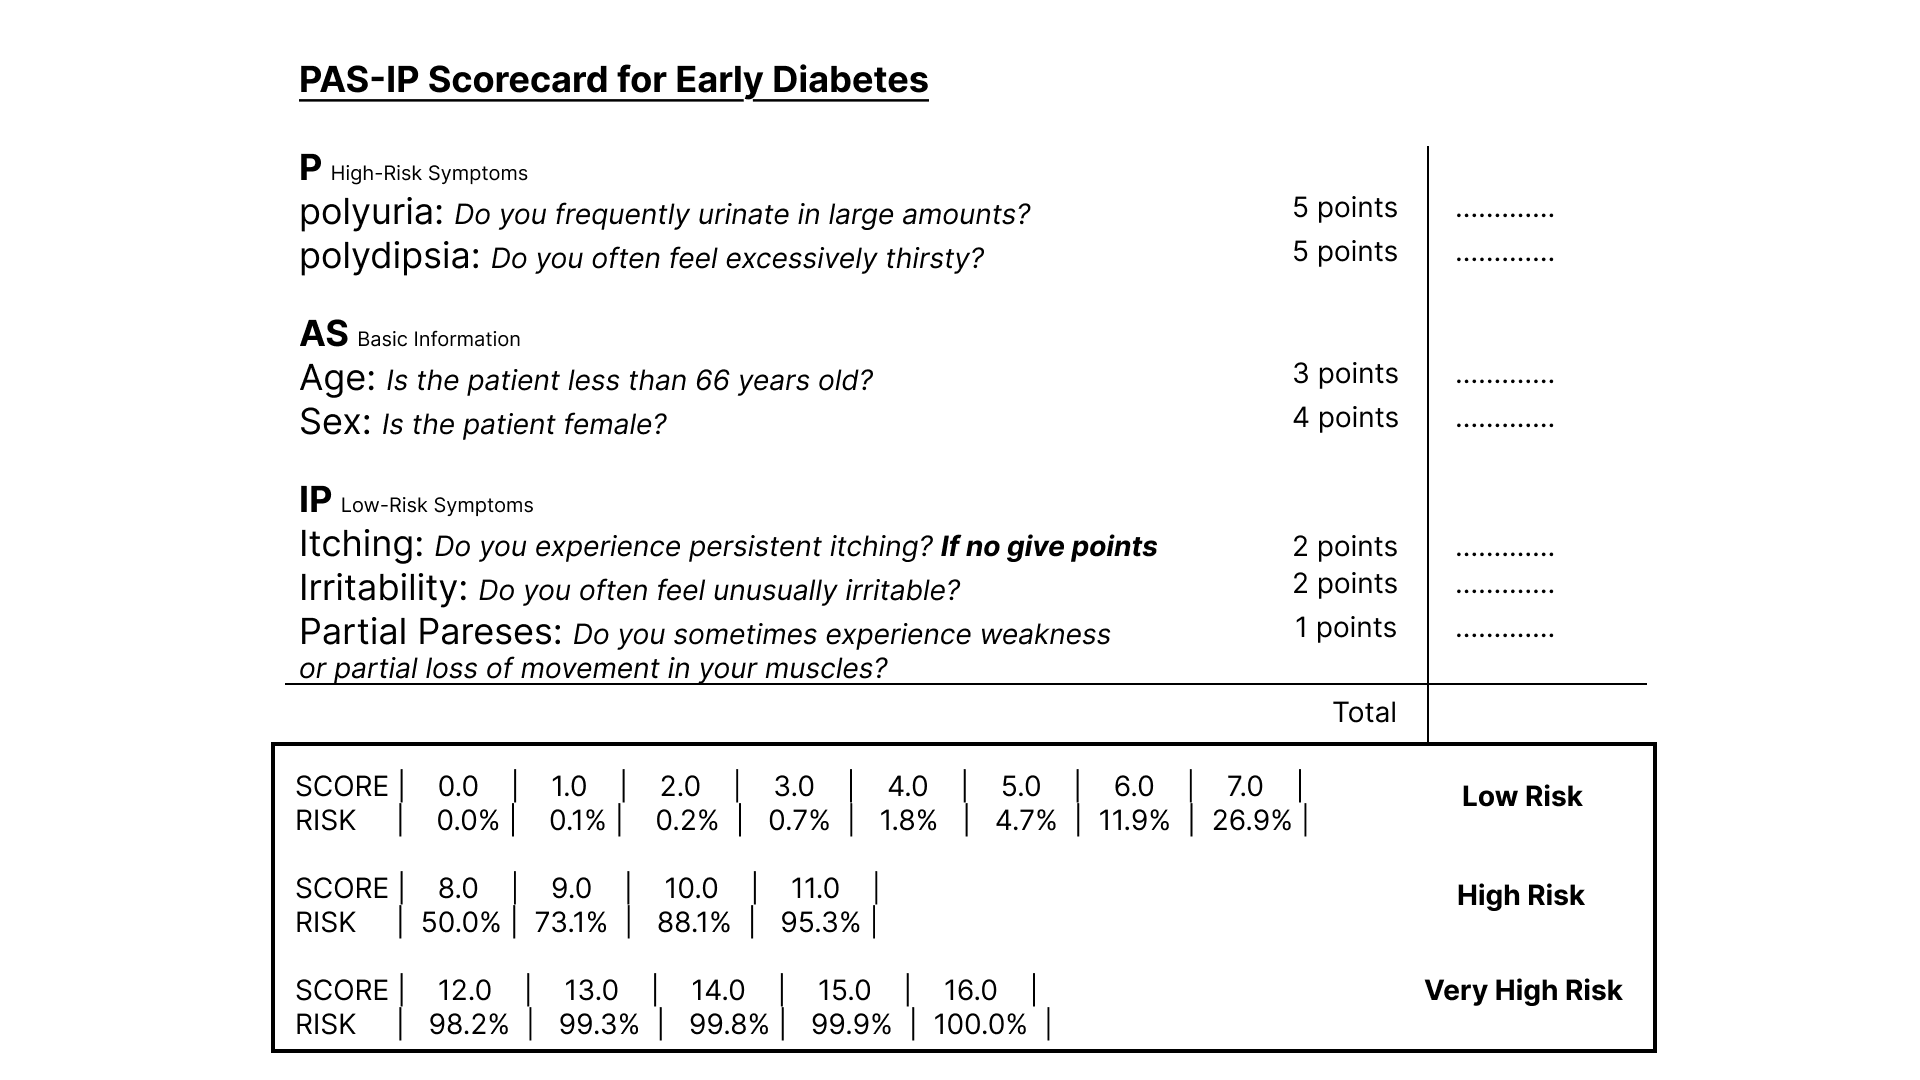

In [ ]:
from IPython.display import Image
Image('/content/drive/My Drive/scorecard.png')

# Conclusion: Scorecard Model
In our evaluation of the scorecard model, we conducted a 5-fold cross-validation with varying levels of sparsity, ranging from 1 to 7. The results showed that a sparsity level of 7 yielded the best performance, achieving the highest accuracy and AUC. The FasterRisk algorithm was used to generate three different scorecards, with the highest test accuracy reaching 91.3% and an AUC of 0.973.

To improve the usability of the scorecard, we transformed the risk table to eliminate negative points, making it more straightforward and easier to interpret for healthcare professionals.

## Questions
1. Does the scorecard achieve a good enough accuracy and auc to be useful?

- Regarding the model’s performance, the scorecard achieves a satisfactory accuracy and AUC, comparable to other models in the field. While the scorecard model offers valuable insights, the Random Forest model still outperforms it with the highest test accuracy of 97.5%. However, it's important to note that while the Random Forest model provides superior accuracy, it lacks interpretability, which the scorecard addresses effectively with its transparent and user-friendly format.

2. Does the scorecard aligns with the feature importance analysis?

- The scorecard also aligns well with the feature importance analysis. The top six most important features identified by SHAP values are all included in the scorecard, confirming its consistency with the feature selection process. Interestingly, the scorecard also recognizes age as a useful feature in predicting the outcome, even though it was not among the highest-ranked features in the SHAP analysis.

Overall, the scorecard offers a balance between performance and interpretability, making it a practical tool for clinical decision-making, while still providing robust predictive accuracy.